In [1]:
!pip install pingouin

In [2]:
from model.model import *
from preprocess import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
download()
alldat = load()
print("Data Loaded. Proceeding to Preprocessing...")
session = 12

Loading data. Patience, padawan ...
Data Loaded. Proceeding to Preprocessing...


In [4]:
diffs = []
for i in range(39): 
    dat = alldat[i]
    for trial in range(len(dat["gocue"])):
        diff = dat["feedback_time"][trial] - dat["response_time"][trial]
        diffs.append(diff)

In [5]:
diffs = np.array(diffs)
print(diffs.shape)
diffs[diffs > 0.01].shape

(10050, 1)


(7362,)

In [6]:
df = spike_preprocess(alldat)

session 0
session 1
session 2
session 3
session 4
session 5
session 6
session 7
session 8
session 9
session 10
session 11
session 12
session 13
session 14
session 15
session 16
session 17
session 18
session 19
session 20
session 21
session 22
session 23
session 24
session 25
session 26
session 27
session 28
session 29
session 30
session 31
session 32
session 33
session 34
session 35
session 36
session 37
session 38
joining dataframes (may take up to a minute)...
done


In [7]:
contrast_diff = df.contrast_left - df.contrast_right
df['pres_difficulty'] = 1 - np.abs(contrast_diff)

# Custom Functions
**Center Spikes around a Specified Axis**

*Note*: Feedback times are indexed at `centered_array[:,max_val]`

In [8]:
def center_spikes(df,center='feedback_time',center_ind=None):
    
    if center_ind is not None:
        max_val = center_ind
    else:
        max_val = np.max(df.center.values)
        
    min_val = np.min(df.center.values)
    max_shift = max_val-min_val

    vals = df.iloc[:, :250].values
    center_vals = df['center'].values
    sh = vals.shape
    centered_array = np.empty([sh[0],int(sh[1] + max_shift)])
    centered_array[:] = np.nan

    for n in np.arange(sh[0]):
        start = int(center_vals[n]-(max_val-max_shift))
        end = int(start + sh[1])
        centered_array[n,start:end] = vals[n]
        
    return centered_array, max_val
    

def centered_plots(df,plot:str='sta',center:str = '',by:str = '',fig:str = '', sub:str = '',filter_:dict = None,sort = 'spike_count',rem_zero_spks=True):
    
    if (by is not '') & (plot == 'heatmap') :
        print('"by" not supported with heatmap. Setting "by" to None.')
        by = ''
    
    if filter_ is not None: 
        for key in filter_.keys(): 
            if isinstance(filter_[key], int):
                df = df[df[key] == filter_[key]]
            else:
                df = df[df[key].isin(filter_[key])]
                
    df[center] = df[center] + 0.5            
    df = df[df[center] < 2.5]
    print(set(df[center]))
                
    if sort is not None:
        if sort == 'spike_count':
            df[sort] = np.sum((df.iloc[:, :250] > 0).to_numpy(),axis=1)
            if rem_zero_spks:
                df = df[df['spike_count'] != 0]
        
        df = df.sort_values(sort,ascending=False)
    
    if fig is not '':
        fig_list = sorted(set(df[fig]))
    else:
        fig_list = ['']
        
    if by is not '':
        by_list = sorted(set(df[by]))
    else:
        by_list = ['']
        
    # Pull out all unique subfigure distinctions 
    if sub is not '':
        sub_list = sorted(set(df[sub]))
    else:
        sub_list = ['']
    
    sub_dims = np.ceil(np.sqrt(len(sub_list)))
    
    if center is not '':
        # Calculate bin of the center
        df['center'] = np.floor(df[center]*1000/10)
    else:
        df['center'] = 0
    for fig_i,fig_val in enumerate(fig_list):
        if plot == 'heatmap':
            plt.figure(fig_i,figsize=(20, 20))
        else:
            plt.figure(fig_i,figsize=(20, 20))
        if fig_val is not '':
            df_fig = df[df[fig] == fig_val]
        else:
            df_fig = df
        for sub_i,sub_val in enumerate(sub_list):
            plt.subplot(np.ceil(sub_dims), np.ceil(sub_dims), sub_i+1)
            if sub_val is not '':
                df_sub = df_fig[df_fig[sub] == sub_val]
            else:
                df_sub = df_fig
            
            max_center_val = np.max(df.center.values)
            
            for by_i,by_val in enumerate(by_list):
                if by_val is not '':
                    df_by = df_sub[df_sub[by] == by_val]
                else:
                    df_by = df_sub

                centered_array, max_val = center_spikes(df_by,center,center_ind = max_center_val)

                if center == 'feedback_time':
                    color = 'blue'
                else: 
                    color = 'green'

                if plot == 'heatmap':
                    plt.imshow(centered_array[:], cmap='hot',extent=((-max_val),centered_array.shape[1]-(max_val),0,centered_array.shape[0]))
                    plt.axvline(x=0,color=color)
                elif plot == 'sta':
                    plt.plot(np.nanmean(centered_array,axis=0),label = "%s: %s"%(by, by_val))
                    plt.axvline(x=max_val,color=color)
                    plt.xlim([0,centered_array.shape[1]])
#                   plt.xlim([max_center_val-50,max_center_val+50])
                    plt.legend()
                else: 
                    print('Plot type not supported. Use "heatmap" or "sta"')

            plt.title(sub + ' : ' + str(sub_val))
            
        plt.tight_layout()
        plt.suptitle(str(fig) + ' : ' + str(fig_val),fontweight='bold', fontsize=16)
        plt.subplots_adjust(top=0.90)

In [9]:
df["center_50"] = 0.5
df["center_trial"] = df["trial"]/100 * 2

In [10]:
df["center_trial"]

0          0.00
1          0.00
2          0.00
3          0.00
4          0.00
           ... 
8787221    6.84
8787222    6.84
8787223    6.84
8787224    6.84
8787225    6.84
Name: center_trial, Length: 8787226, dtype: float64

{1.6868187947551405, 1.3276130676801188, 2.0468245345853546, 1.937622793503536, 1.4860155932054084, 1.6420180804651636, 1.8568215052305135, 1.7868203891524388, 1.3860139988081244, 1.6540182717928644, 1.8700217156909673, 1.7016190307259933, 1.170010554909993, 1.5420164860678938, 2.0032238394281308}


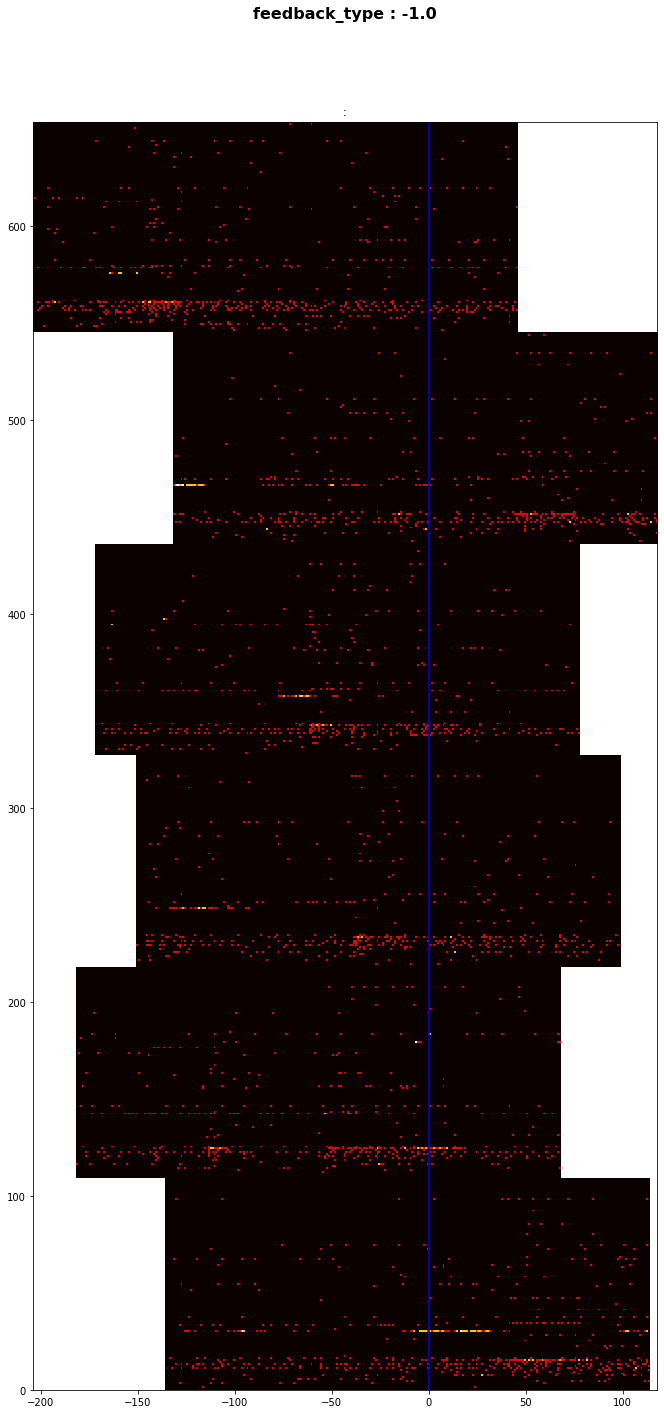

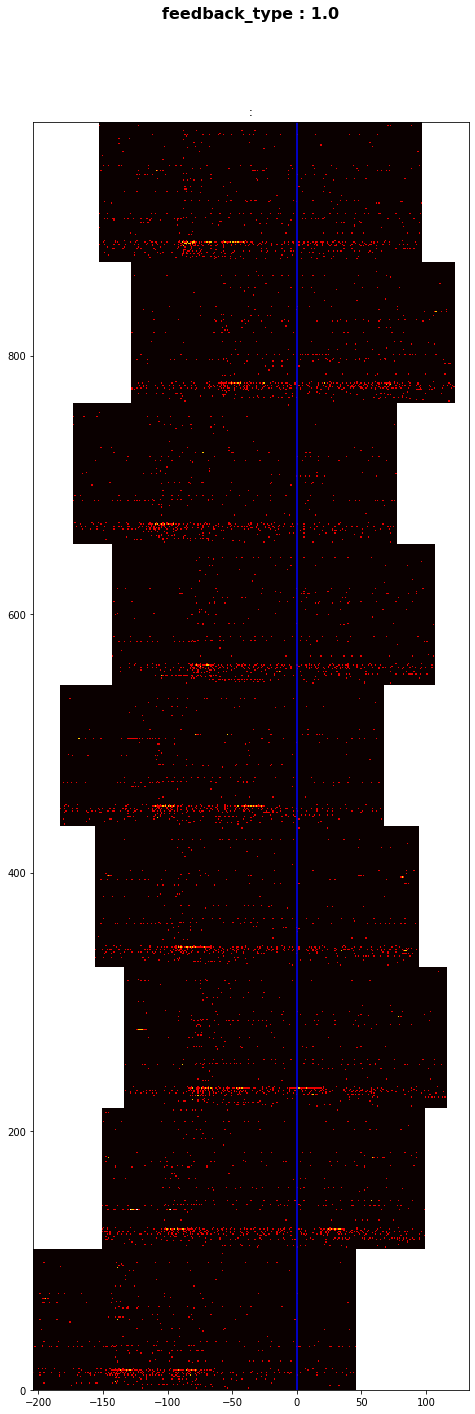

In [11]:
# Define your Filter
f = {"region": ["ACA"],"session": [0],"trial": np.arange(20)}
plot = 'heatmap'
spike_center = 'feedback_time'
subplots= ''
figures = 'feedback_type'

# Plot
centered_plots(df,plot=plot,center=spike_center,fig=figures,sub=subplots,filter_=f, sort = None)